Import modules
---

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches

from datetime import datetime, timedelta
import heliopy.data.helios as helios
import astropy.units as u
import astropy.constants as const

import sys
sys.path.append('library')
import axisformat
from derived import calc_derived

from pandas.plotting import _converter
_converter.register()

comps = ['x', 'y', 'z']

Import data
----

In [2]:
probe = '1'

# Start and end times to plot context around the structure (bottom 4 panels of plot below)
contextstart = datetime(1976, 3, 25)
contextend = datetime(1976, 3, 29)
# Start and end times for "zoomed in" panels
starttime = datetime(1976, 3, 26, 21, 30, 0)
endtime = datetime(1976, 3, 26, 23, 0, 0)
# Start and end of actual structure
bloblims = (datetime(1976, 3, 26, 22, 17, 0), datetime(1976, 3, 26, 22, 35, 0))

overview = helios.corefit(probe, contextstart, contextend)
zoom = helios.corefit(probe, starttime, endtime)

Calculate derived plasma values
---

In [3]:
# Calculate derived quantities
overview = calc_derived(overview)
zoom = calc_derived(zoom)

# Take 30 minute means for the overview data
overview = overview.resample('10min', loffset=timedelta(minutes=5)).mean()

Plot figure
---

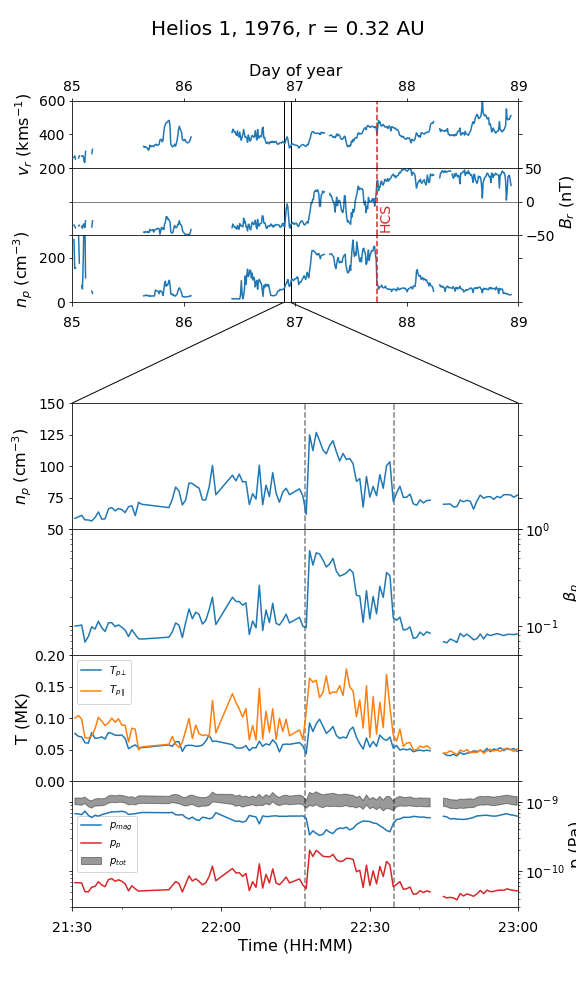

In [4]:
# Plot title string
title = 'Helios {}, {}, r = {:.2f} AU'.format(probe, starttime.year,
                                             overview['r_sun'].mean())
kwargs = {'marker': 'o', 'markersize': 0, 'zorder': 10}
fontsize = 16

fig = plt.figure(figsize=(8, 14), facecolor='w')

ntop = 3
nbottom = 4

# Add top two axes
gs_top = plt.GridSpec(ntop, 1, bottom=0.7, top=0.9, hspace=0)
topax = fig.add_subplot(gs_top[0, :])
other_topaxs = [fig.add_subplot(gs_top[i, :], sharex=topax) for i in range(1, ntop)]
topaxs = [topax] + other_topaxs

# Add bottom four axes
gs_base = plt.GridSpec(nbottom, 1, bottom=0.1, top=0.6, hspace=0)
ax = fig.add_subplot(gs_base[0, :])
other_axs = [fig.add_subplot(gs_base[i, :], sharex=ax) for i in range(1, nbottom)]
axs = [ax] + other_axs

############################
# Plot overview quantities #
############################
fig.suptitle(title, size=fontsize + 4)

# Radial velocity
topaxs[0].plot(overview['vp_x'])
topaxs[0].set_ylabel('$v_{r}$ (kms$^{-1}$)', size=fontsize)
topaxs[0].set_ylim(200, 600)

# Radial magnetic field
topaxs[1].plot(overview['Bx'])
topaxs[1].set_ylabel('$B_{r}$ (nT)', size=fontsize)
topaxs[1].set_ylim(-50, 50)
topaxs[1].axhline(0, color='k', alpha=0.5, linewidth=1)

topaxs[2].plot(overview['n_p'])
topaxs[2].set_ylabel('$n_{p}$ (cm$^{-3}$)', size=fontsize)
topaxs[2].set_ylim(0, 300)


# Add vertical lines for HCS and zoom in limits
for ax in topaxs:
    ax.tick_params(axis='both', which='major', labelsize=fontsize - 2)
    ax.axvline(datetime(1976, 3, 27, 17, 30), linestyle='--', color='C3')
    for time in (starttime, endtime):
        ax.axvline(time, color='k', zorder=0, linewidth=1)

axisformat.tidysubplots(topaxs)
# Move x-axis to top of plots
topaxs[0].xaxis.set_visible(True)
topaxs[0].xaxis.tick_top()
topaxs[1].xaxis.set_visible(False)

# Set axis locator/formatter
topaxs[0].xaxis.set_major_locator(mdates.DayLocator())
topaxs[0].xaxis.set_major_formatter(mdates.DateFormatter('%-j'))
topaxs[0].set_xlim(contextstart, contextend)
topaxs[0].set_xlabel('Day of year', size=fontsize)
topaxs[0].xaxis.set_label_position('top')
# Add HCS text
topaxs[1].text(datetime(1976, 3, 27, 18), -18, 'HCS',
               rotation=90, color='C3', size=fontsize - 2)

##############################
# Plot zoomed in quantities #
##############################
# Number density
axs[0].plot(zoom['n_p'], label=r'$n_{p}$', **kwargs)
axs[0].set_ylabel(r'$n_{p}$ (cm$^{-3}$)', size=fontsize)
axs[0].set_ylim(50, 150)

# Plasma beta
axs[1].plot(zoom['Beta'], **kwargs)
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\beta_{p}$', size=fontsize)
axs[1].set_ylim(5e-2, 1)

# Temperatures
axs[2].plot(zoom['Tp_perp'] / 1e6, label=r'$T_{p\perp}$', **kwargs)
axs[2].plot(zoom['Tp_par'] / 1e6, label=r'$T_{p\parallel}$', **kwargs)
axs[2].set_ylabel(r'T (MK)', size=fontsize)
axs[2].set_ylim(0, 0.2)

# Pressures
axs[3].fill_between(zoom.index, zoom['p_tot_min'], zoom['p_tot_max'],
                    color='k', alpha=0.4, label=r'$p_{tot}$')
axs[3].plot(zoom['p_mag'], label=r'$p_{mag}$', **kwargs, color='C0')
axs[3].plot(zoom['p_th'], label=r'$p_{p}$', color='C3')

axs[3].set_yscale('log')
axs[3].set_ylabel('p (Pa)', size=fontsize)
axs[3].set_ylim(3e-11, 2e-9)

# Plot formatting
axs[2].legend(loc='upper left')
axs[3].legend(loc='center left')
axisformat.tidysubplots(axs)
for ax in topaxs:
    ax.yaxis.set_ticks_position('both')
for ax in axs:
    ax.yaxis.set_ticks_position('both')
    ax.axvline(bloblims[0], color='k', zorder=0, alpha=0.5, linestyle='--')
    ax.axvline(bloblims[1], color='k', zorder=0, alpha=0.5, linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=fontsize - 2)

axs[-1].xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[10, 20, 40, 50]))
axs[-1].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 30]))
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[-1].set_xlim(starttime, endtime)
axs[-1].set_xlabel('Time (HH:MM)', size=fontsize)

########################
# Add connection lines #
########################
for time in (starttime, endtime):
    connector = patches.ConnectionPatch((time, 0), (time, 150), 'data', axesA=topaxs[-1], axesB=axs[0])
    topaxs[-1].add_patch(connector)
fig.savefig('single_structure.pdf', bbox_inches='tight');